# Normalisation and dimentionality reduction

## Motivation

After removing low quality cells in our data, we address count differences across cells that can be caused by the stochastic nature or technical artifacts of the scATAC-seq assay. This step if referred to as normalization. In current scATAC-seq data processing pipelines, normalization is often closely connected to the subsequent step of dimensionality reduction. Therefore, we demonstrate these steps in context of each other, explaining how different processing strategies affect the feature counts, handle differences in sequencing depth and learn a low-dimensional representation of each cell. This low-dimensional representation, also referred to as low-dimensional embedding, aims to capture as much biologically meaningful variation across cells as possible, while removing noise. Furthermore, it allows for computationally efficient downstream tasks like visualizations and clustering of cells.

## Overview

To provide a first overview, the processing strategies can include:
- **Feature transformations**, e.g. binarization and/or term frequency-inverse document frequency (TF-IDF) transformation
- **Linear and non-linear dimensionality reduction** of the raw or transformed features, e.g. based on singular value decomposition {cite}`atac:archr`, {cite}`atac:Signac`, latent Dirichlet allocation {cite}`atac:pyCisTopic`, spectral embedding {cite}`atac:snapatac` and autoencoder-based dimentionality reduction {cite}`atac:PeakVI`

Depending on the transformation and dimensionality reduction method chosen, feature selection to reduce noise and computational resources can be performed in between. So far, mostly simple approaches such as a minimal number of cells a feature has to be present or scRNA-based feature selection methods have been applied. Here, we follow this idea and rely on our feature selection step which was part of QC and removed features present in less than 15 cells.

## Binarization and feature transformations

There is an ongoing discussion whether binarization  sufficiently adjusts count differences, following the biological principle that chromatin state within a single cell is in general of binary nature (open or closed). Despite multiple successfully applied analysis workflows suggesting binarization, there is growing evidence, that binarization might remove biological information. Some arguments for a count-preserving approach are the sequence bias of the Tn5-transposase (including GC-bias), nucleosome occupancy or TF binding {cite}`atac:martens_modeling_2022`. These factors likely increase their impact in case of larger genomic regions such as peaks compared to small uniform 500-bp windows, but a systematic benchmark is outstanding. Worth mentioning is that this discussion assumes that PCR duplicated have been accounted for in raw data processing.

A commonly used transformation performed in scATAC-seq data analysis is the term frequency-inverse document frequency (TF-IDF) transformation. It has been adapted from natural language processing and results in up-weighting of rare features among many common with the aim of detecting rare cell state more easily. Since the term frequency is relative to the total number of features detected in each cell, differences in sequencing depth, are accounted for to some extend (more on this, see below).


In [1]:
import scanpy as sc
import muon as mu
from muon import atac as ac   # the module containing function for scATAC data processing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Setting figure parameters
sc.settings.verbosity = 0
sns.set(rc={"figure.figsize":(4, 3.5),
            "figure.dpi":100})
sns.set_style("whitegrid")

/opt/saturncloud/envs/saturn/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/saturncloud/envs/saturn/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/saturncloud/envs/saturn/lib/python3.8/site-packages/umap/distances.py:1086: Num

We start with reloading the atac data with low quality cells filtered.

In [2]:
atac = sc.read_h5ad('output/atac_qc_filtered.h5ad')

Next, we binarize the data and save it in a new layer.

In [4]:
ac.pp.binarize(atac)
atac.layers['binarized']=atac.X

We reset the adata.X back to the raw counts and perform the TF-IDF transformation. As a scaling factor we choose $10^{4}$ since this reflects an average total number of fragment counts in our data set (see previous chapter). **(TODO: Elaborate on TF-IDF flavors)**

In [5]:
atac.X = atac.layers['counts']
ac.pp.tfidf(atac, scale_factor=1e4)
atac.layers['tf_idf']=atac.X

In [6]:
atac

AnnData object with n_obs × n_vars = 15286 × 154015
    obs: 'scDblFinder_score', 'AMULET_pVal', 'AMULET_qVal', 'AMULET_negLog10qVal', 'n_features_per_cell', 'total_fragment_counts', 'log_total_fragment_counts', 'nucleosome_signal', 'nuc_signal_filter', 'tss_score'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'atac', 'files'
    layers: 'counts', 'binarized', 'tf_idf'

This results in an `AnnData` object with three layers containing the raw counts, the binarized features and the TF-IDF transformed features.

## Dimensionality reduction

To obtain a lower dimensional representations of each cell, that captures as much biologically meaningful variation, while removing technical effects, several approaches have been suggested.

**TODO: Improve the following**
Methods based on latent semantic indexing {cite}`atac:archr`, {cite}`atac:Signac`, latent Dirichlet allocation {cite}`atac:pyCisTopic` and spectral embedding {cite}`atac:snapatac` were shown to perform best for downstream clustering and cell annotation. More recently, autoencoder-based dimentionality reduction has been suggested with comparable performance according to the publications of the methods. Here we showcase three approaches based on latent semantic indexing which combines the TF-IDF tranformation with SVD, a latent Dirichlet allocation approach which follows the idea of topic modeling and an autoencoder-based approach {cite}`atac:PeakVI`. We do recommend to also investigate spectral embeddings as implemented in {cite}`atac:snapatac` that were designed for processing features defined by uniform windows across the genome.

### Latent semantic indexing (LSI)

To receive a low dimentional representation of each cell, we first perform SVD on the TF-IDF transformed data using the ```ac.tl.lsi```function of atac module of `muon`. By default, it uses the adata.X slot, which still contains the TF-IDF transformed features. As a result a matrix containing the low-dimentional embedding will be added to the `atac.obsm['X_lsi']`slot.

In [7]:
ac.tl.lsi(atac)

In [8]:
atac

AnnData object with n_obs × n_vars = 15286 × 154015
    obs: 'scDblFinder_score', 'AMULET_pVal', 'AMULET_qVal', 'AMULET_negLog10qVal', 'n_features_per_cell', 'total_fragment_counts', 'log_total_fragment_counts', 'nucleosome_signal', 'nuc_signal_filter', 'tss_score'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'atac', 'files', 'lsi'
    obsm: 'X_lsi'
    varm: 'LSI'
    layers: 'counts', 'binarized', 'tf_idf'

Despite the use of TF-IDF values, some of the first LSI components can still be associated with the total number of counts per cell. Therefore, we plot the correlation of if the first 30 components with the total counts per cell.

In [9]:
# here we define a function to create the plot

def plot_component_cor(adata, embed, covariate, n_comps=30):
    
    if n_comps > adata.obsm[embed].shape[1]:
        print('n_comps greater than available number of components, setting n_comps to number of available ('+str(adata.obsm[embed].shape[1])+')')
        n_comps = adata.obsm[embed].shape[1]
    
    cor_mat = np.corrcoef(adata.obsm[embed][:,:n_comps], adata.obs[covariate], rowvar=False)
    cor_vals = cor_mat[:,cor_mat.shape[1]-1][:-1]
    component_num = [i for i in range(len(cor_vals))]
    
    with plt.rc_context({"figure.figsize":(n_comps/3,3.5)}):
        sns.scatterplot(x=component_num, y=cor_vals, color='black')
        plt.xlabel('LSI components')
        plt.ylabel('Correlation')
        plt.xticks(range(n_comps))
        plt.ylim(-1,1)
        plt.title('Correlation of '+embed+' components with '+covariate)
        plt.show()
    

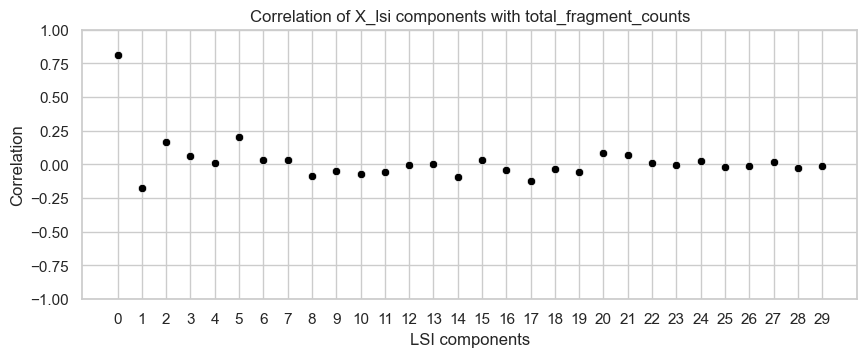

In [10]:
# plot correlation of dim reduced components with 
plot_component_cor(adata=atac,
                  embed='X_lsi',
                  covariate='total_fragment_counts')

The plot shows that there is a strong correlation (which can be positive or negative) between the first LSI components and the total counts per cell. Therfore, we remove this component in the adata slots, which store the low dimentional embedding. For demonstration purposes on how this changes cellular representation, we save the full set of LSI components in a separate slots before.

In [11]:
# save full set of LSI components
atac.obsm['X_lsi_full'] = atac.obsm['X_lsi']
atac.varm["LSI_full"] = atac.varm["LSI"]
atac.uns["lsi_full"] = atac.uns["lsi"]

Now, let's remove the first LSI component.

In [12]:
atac.obsm['X_lsi'] = atac.obsm['X_lsi'][:,1:]
atac.varm["LSI"] = atac.varm["LSI"][:,1:]
atac.uns["lsi"]["stdev"] = atac.uns["lsi"]["stdev"][1:]

In [13]:
atac

AnnData object with n_obs × n_vars = 15286 × 154015
    obs: 'scDblFinder_score', 'AMULET_pVal', 'AMULET_qVal', 'AMULET_negLog10qVal', 'n_features_per_cell', 'total_fragment_counts', 'log_total_fragment_counts', 'nucleosome_signal', 'nuc_signal_filter', 'tss_score'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'atac', 'files', 'lsi', 'lsi_full'
    obsm: 'X_lsi', 'X_lsi_full'
    varm: 'LSI', 'LSI_full'
    layers: 'counts', 'binarized', 'tf_idf'

To give an impression on how the dimensionality reduced spaces differ, let's generate UMAPs based on the full set of LSI components and the first components removed.

UMAP based on the full set of LSI components


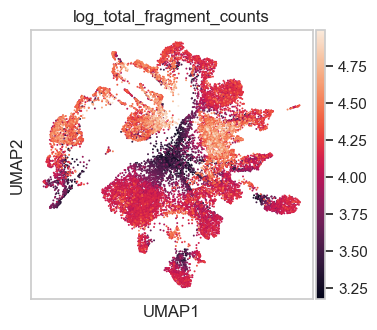

In [14]:
sc.pp.neighbors(atac, use_rep="X_lsi_full")
sc.tl.umap(atac, spread=1.5, min_dist=.5, random_state=42)
print('UMAP based on the full set of LSI components')
sc.pl.umap(atac, color=["log_total_fragment_counts"])

UMAP based on LSI components not correlated to the total counts


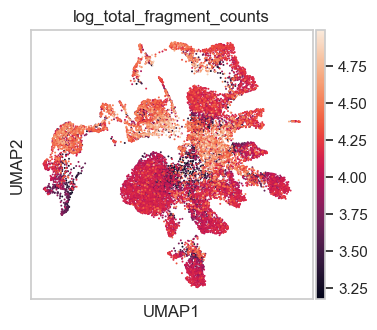

In [15]:
sc.pp.neighbors(atac, use_rep="X_lsi")
sc.tl.umap(atac, spread=1.5, min_dist=.5, random_state=42)
print('UMAP based on LSI components not correlated to the total counts')
sc.pl.umap(atac, color=["log_total_fragment_counts"])

By comparing the two UMAPs, we can observe that the total count per cell has a larger impact on the overall staructure of the data with low count cells mostly clustering in the center. After removing the first LSI component, also cells with lower counts are distributed within the other cell populations.

In [3]:
atac.write('output/atac_lsi_temp.h5ad')

### Autoencoder-based dimensionality reduction

In [3]:
atac = sc.read_h5ad('output/atac_lsi_temp.h5ad')

As in scRNA-seq data, deep learning models have been proposed to perform dimensionality reduction, batch correction and other analysis tasks. These approaches are highly suitable for large-scale data sets up to millions of cells due to their efficient use of GPUs. Note that with CPUs the model training step can take a long time. Therefore, if one is not interested in highly rare cell types, one can consider to remove additional features (e.g. present in at least 1% of the cells).

To get started, we load the `scvi` package.

In [4]:
import scvi
scvi.settings.seed = 42

/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
Global seed set to 42


Most models that part of [scvi-tools](https://scvi-tools.org/) expect raw counts as inputs. Therefore, we copy them from the corresponding `layer` to `adata.X`.

In [5]:
atac.X = atac.layers['counts']

If features are present in only a few cells they can either be specific for a rare cell type, or might just represent noise in the data. Depending on the goal of the analysis, one can remove features e.g. to be present in at least 1% of cells. The advantage of this is a reduction of computational resources needed and potentially lowering the risk of overfitting (when the model starts fitting noise instead of true signals in the data). Since we took care of feature selection in the QC section, we commented out the following cell.

In [7]:
# min_cells = int(atac.shape[0] * 0.01)
# print('Number of cells corresponding to 1%:', min_cells)

# # in-place filtering of regions
#sc.pp.filter_genes(atac_scvi, min_cells=min_cells)

Next, we set up the data and the model and train it.

In [7]:
scvi.model.PEAKVI.setup_anndata(atac)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [8]:
pvi = scvi.model.PEAKVI(atac)
pvi.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 95/500:  19%|█▉        | 95/500 [39:46<2:49:31, 25.12s/it, v_num=1, train_loss_step=5.22e+7, train_loss_epoch=2.56e+8]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 16770.336. Signaling Trainer to stop.


**ToDo** add note on the training process

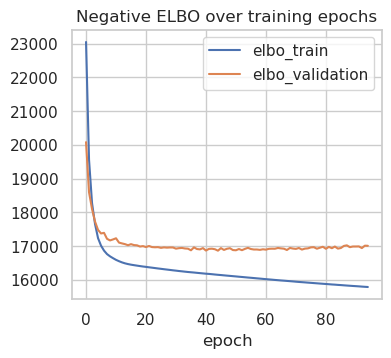

In [13]:
fig, ax = plt.subplots(1, 1)
pvi.history["elbo_train"].plot(ax=ax, label="train")
pvi.history["elbo_validation"].plot(ax=ax, label="validation")
ax.set(title="Negative ELBO over training epochs") #, ylim=(1200, 1400)
ax.legend()
plt.show()

Since the model itself can be used to regenerate the dimensionality-reduced embedding and other downstream tasks, we save it in a separate directory.

In [9]:
# Saving the model for potential later use
pvi.save("output/trained_model_peakVI", overwrite=True)

# Can be loaded using
# pvi = scvi.model.PEAKVI.load("output/trained_model_peakVI", adata=atac)

The low-dimensional representation of each cell is the latent representation, which we extract from the model and add to our `atac` object.

In [10]:
latent = pvi.get_latent_representation()
atac.obsm["X_PeakVI"] = latent

print(latent.shape)

(15286, 19)


Let's regenerate the neighborhood graph and visualize the result in a UMAP.

UMAP based on PeakVI components


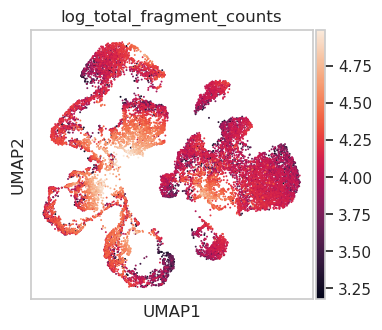

In [24]:
sc.pp.neighbors(atac, use_rep="X_PeakVI")
sc.tl.umap(atac, spread=1.5, min_dist=.5, random_state=42)
print('UMAP based on PeakVI components')
sc.pl.umap(atac, color=["log_total_fragment_counts"])

In [30]:
## TEMPORARY, CAN BE REMOVED
atac.write_h5ad('output/atac_peakvi_temp.h5ad')

### Latent Dirichlet allocation (LDA)

In [3]:
## TEMPORARY, CAN BE REMOVED
atac = sc.read_h5ad('output/atac_peakvi_temp.h5ad')

An alternative dimensionality reduction approach is based on latent Dirichlet allocation as proposed in the CisTopic workflow. Here, we make use of a reimplementation of the package in python. The input matrix for this topic modeling approach is the binarized peak-by-cell matrix.

In [27]:
# #Note on installation: Set-up separate scienicplus environment via:
# mamba create --name scenicplus python=3.8
# mamba activate scenicplus
# git clone https://github.com/aertslab/scenicplus
# cd scenicplus
# pip install -e .
# mamba install -c conda-forge jupyterlab
# pip install muon
# mamba install -c conda-forge mallet

In [3]:
import os
from pycisTopic.cistopic_class import run_cgs_models, run_cgs_models_mallet, create_cistopic_object, evaluate_models
from pycisTopic.clust_vis import harmony

Since `pycistopic` derives genomic coordinates from the peak names. Therefore, we double check the formatting to prevent errors during the generation of the `CistopicObject` object. Names should follow the convention `chromosome:start-end`, e.g. `chr1:2345-3456`.

In [4]:
atac.var_names 

Index(['chr1:9763-10648', 'chr1:115270-116168', 'chr1:181107-181768',
       'chr1:183973-184845', 'chr1:191237-192111', 'chr1:267555-268454',
       'chr1:585750-586647', 'chr1:629372-630390', 'chr1:631346-632170',
       'chr1:633515-634557',
       ...
       'KI270726.1:38237-39150', 'KI270726.1:41488-42282',
       'KI270711.1:22590-23476', 'KI270713.1:3919-4834',
       'KI270713.1:15812-16542', 'KI270713.1:21361-22256',
       'KI270713.1:29645-30508', 'KI270713.1:32401-33088',
       'KI270713.1:34369-35136', 'KI270713.1:36970-37884'],
      dtype='object', length=154015)

Since the naming convention is correct, we directly use the index as the region_names we provide as input to the `create_cistopic_object` fuction

In [5]:
region_names = atac.var_names 

# In case symbols need to be replaced, this would be an example of replacing the first (n=1) hyphen with a colon
#region_names = region_names.str.replace('-', ':', n=1)

We also transpose (`.T`) the count matrix to a sparse.csr_matrix matrix (`.tocsr()`) such that cells are columns, and regions are rows.

In [6]:
cistopic_obj = create_cistopic_object(atac.X.T.tocsr(),
                                      cell_names=atac.obs_names,
                                      region_names=region_names)

2023-06-12 23:30:45,693 cisTopic     INFO     Creating CistopicObject
2023-06-12 23:30:47,698 cisTopic     INFO     Done!


Next, we add the cell meta data to the object. In the `cistopic_obj`, the barcode names were extended with a '___cisTopic' tag, which we add to the data frame index as well to ensure correct matching of the cells to the meta data.

In [7]:
metadata = atac.obs
metadata.index = metadata.index + '___cisTopic'

In [8]:
cistopic_obj.cell_data = cistopic_obj.cell_data.join(metadata)

Let's take a quick look at the meta data we added.

In [9]:
cistopic_obj.cell_data.head()

,cisTopic_nr_frag,cisTopic_log_nr_frag,cisTopic_nr_acc,cisTopic_log_nr_acc,sample_id,scDblFinder_score,AMULET_pVal,AMULET_qVal,AMULET_negLog10qVal,n_features_per_cell,total_fragment_counts,log_total_fragment_counts,nucleosome_signal,nuc_signal_filter,tss_score,_scvi_batch,_scvi_labels
AAACAGCCAAGCTTAT-1___cisTopic,5601.0,3.748266,2689.0,3.429591,cisTopic,0.028191,0.994851,0.994851,0.002242,2689,5601.0,3.748266,0.740595,NS_PASS,4.268584,0,0
AAACAGCCATGAAATG-1___cisTopic,7729.0,3.888124,3738.0,3.572639,cisTopic,0.063412,0.994851,0.994851,0.002242,3738,7729.0,3.888123,0.645230,NS_PASS,4.271634,0,0
AAACAGCCATGTTTGG-1___cisTopic,11002.0,4.041472,4978.0,3.697055,cisTopic,0.026449,0.967723,0.994851,0.002242,4978,11002.0,4.041471,0.652846,NS_PASS,4.003789,0,0
AAACATGCAACGTGCT-1___cisTopic,11672.0,4.067145,5231.0,3.718585,cisTopic,0.019928,0.994851,0.994851,0.002242,5231,11672.0,4.067145,0.930780,NS_PASS,7.554662,0,0
AAACATGCAATATAGG-1___cisTopic,13146.0,4.118794,5806.0,3.763877,cisTopic,0.067305,0.967723,0.994851,0.002242,5806,13146.0,4.118793,0.920955,NS_PASS,4.903370,0,0


We can see, the meta data generated by cistopic and our values were merged correctly.
**ToDo: Explain model parameters**

In [ ]:
# Run models
path_to_mallet_binary='/opt/saturncloud/envs/saturn/bin/mallet'
n_topics = [5, 10, 15, 20, 30, 40, 50, 60, 70, 80]
save_path = 'output/cistopic_models/'

models=run_cgs_models_mallet(path_to_mallet_binary,
                cistopic_obj,
                n_topics=n_topics,
                n_cpu=8,
                n_iter=500,
                random_state=42,
                alpha=50,
                alpha_by_topic=True,
                eta=0.1,
                eta_by_topic=False,
                tmp_path=save_path, #Use SCRATCH if many models or big data set
                save_path=save_path)

2023-06-12 23:31:49,795 cisTopic     INFO     Formatting input to corpus
2023-06-12 23:31:51,254 gensim.corpora.dictionary INFO     adding document #0 to Dictionary<0 unique tokens: []>
2023-06-12 23:32:37,551 gensim.corpora.dictionary INFO     adding document #10000 to Dictionary<0 unique tokens: []>
2023-06-12 23:33:03,569 gensim.corpora.dictionary INFO     built Dictionary<154015 unique tokens: ['0', '1', '2', '3', '4']...> from 15286 documents (total 92353877 corpus positions)
2023-06-12 23:33:03,570 cisTopic     INFO     Running model with 5 topics
2023-06-12 23:33:03,575 LDAMalletWrapper INFO     Serializing temporary corpus to output/cistopic_models/corpus.txt
2023-06-12 23:37:05,051 LDAMalletWrapper INFO     Converting temporary corpus to MALLET format with /opt/saturncloud/envs/saturn/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input output/cistopic_models/corpus.txt --output output/cistopic_models/corpus.mallet
2023-06-12 23

**ToDo: Note one model evaluation**

In [ ]:
model=evaluate_models(models,
                    select_model=None,
                    return_model=True,
                    metrics=['Minmo_2011', 'loglikelihood'],
                    plot_metrics=False)

In [ ]:
# Add model to cisTopicObject
cistopic_obj.add_LDA_model(model)

In [ ]:
model = cistopic_obj.selected_model

X_emb = model.cell_topic.T
X_emb.index = X_emb.index.str.split('__').str[0]

atac.obsm['X_cistopic'] = X_emb

Generate UMAP to check embedding

In [ ]:
sc.pp.neighbors(atac, use_rep="X_cistopic")
sc.tl.umap(atac, spread=1.5, min_dist=.5, random_state=42)
print('UMAP based on CisTopic components')
sc.pl.umap(atac, color=["log_total_fragment_counts"])

**ToDo: Note on the cistopic output***

Saving the object for next steps

In [45]:
atac.write_h5ad('output/atac_qc_dimred.h5ad')

## Key takeaways

**ToDo**

## References

```{bibliography}
:filter: docname in docnames
:labelprefix: atac
```

## Contributors

**ToDo**